In [9]:

import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn import metrics


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb

%matplotlib inline

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [6]:
data = pd.read_csv("TRAIN.csv", index_col=0, parse_dates=['Date'])
unseen = pd.read_csv("TEST_FINAL.csv",index_col=0, parse_dates=['Date'])

print(data.shape)
print(unseen.shape)

NameError: name 'pd' is not defined

In [5]:
data.head()

NameError: name 'data' is not defined

In [ ]:
data = data.sort_values(['Date', 'Store_id'], ascending=[True, True])

In [ ]:
data.info()

In [ ]:
train      = data[data['Date']<= datetime(2018,12,31)]
validation = data[data['Date']> datetime(2018,12,31)]
print(train.shape)
print(validation.shape)

In [ ]:
def create_forecaster():
    
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=7, strategy="recursive")
    
    return forecaster

def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test))+1
    y_pred = gscv.predict(fh=fh)
    return y_pred

In [ ]:
lgb_results = pd.DataFrame()

store_lgbm1_results = {}
for i in range(1,366):
    
    train_i = train[train['Store_id']==i]
    ts_i_sales = train_i.set_index('Date').Sales
    ts_i_sales.index = ts_i_sales.index.to_period("D")
    
    validation_i = validation[validation['Store_id']==1]
    ts_i_sales_valid = validation_i.set_index('Date').Sales
    ts_i_sales_valid.index = ts_i_sales_valid.index.to_period("D")
    
    fh = ForecastingHorizon(pd.PeriodIndex(pd.date_range("2019-01-01", periods=len(ts_i_sales_valid), freq="D")), is_relative=False)
    cutoff = pd.Period("2018-12-31", freq="D")
    print(cutoff)
    fh = fh.to_relative(cutoff)
    
    param_grid = {"window_length": [7, 14, 21, 28, 35, 42]} # parameter set to be grid searched
    forecaster = create_forecaster()
    y_pred = grid_serch_forecaster(ts_i_sales, ts_i_sales_valid, forecaster, param_grid)
    store_lgbm1_results['LGBM1_Store_'+i] = y_pred


In [ ]:
store_lgbm1_results = pd.DataFrame(store_lgbm1_results)
store_lgbm1_results.head()

## Naive Forecasting

In [399]:

fh = ForecastingHorizon(pd.PeriodIndex(pd.date_range("2019-01-01", periods=len(ts_1_sales_valid), freq="D")), is_relative=False)
fh

ForecastingHorizon(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
             '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
             '2019-01-09', '2019-01-10',
             ...
             '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
             '2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29',
             '2019-05-30', '2019-05-31'],
            dtype='period[D]', length=151, is_relative=False)

In [400]:
cutoff = pd.Period("2018-12-31", freq="D")
print(cutoff)
fh = fh.to_relative(cutoff)
fh

2018-12-31


ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            142, 143, 144, 145, 146, 147, 148, 149, 150, 151],
           dtype='int64', length=151, is_relative=True)

<AxesSubplot:xlabel='Date'>

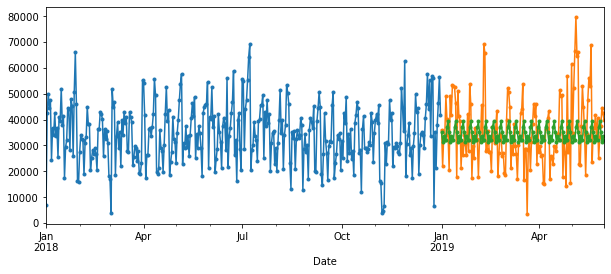

In [401]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="mean", sp=7)
forecaster.fit(ts_1_sales)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ts_1_sales.plot(ax=ax, label='y_train', style='.-')
ts_1_sales_valid.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')

<AxesSubplot:xlabel='Date'>

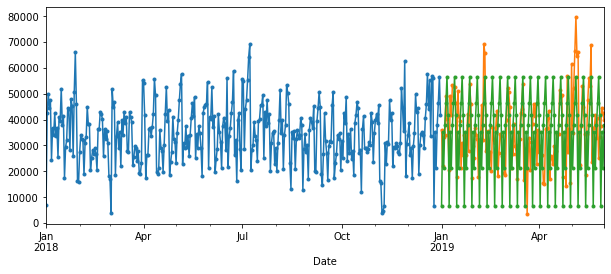

In [402]:

forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(ts_1_sales)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ts_1_sales.plot(ax=ax, label='y_train', style='.-')
ts_1_sales_valid.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')

<AxesSubplot:xlabel='Date'>

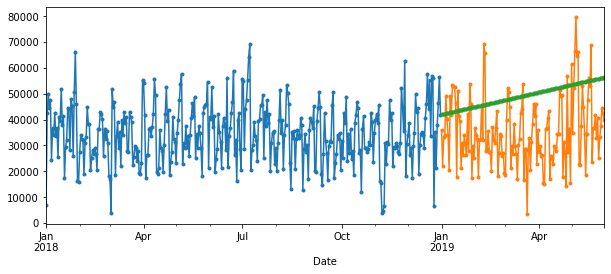

In [403]:
forecaster = NaiveForecaster(strategy="drift", sp=7)
forecaster.fit(ts_1_sales)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ts_1_sales.plot(ax=ax, label='y_train', style='.-')
ts_1_sales_valid.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')

## ARIMA

In [404]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(max_p=9, suppress_warnings=True)
forecaster.fit(ts_1_sales)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -3878.959
Date:                Sun, 19 Sep 2021   AIC                           7775.917
Time:                        13:21:00   BIC                           7811.016
Sample:                             0   HQIC                          7789.866
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.536e+04   4648.517      7.606      0.000    2.62e+04    4.45e+04
ar.L1          0.4822      0.076      6.340      0.000       0.333       0.631
ar.L2         -0.0609      0.053     -1.153      0.249      -0.164       0.043
ar.L3         -0.8748      0.053    -16.505      0.000      -0.979      -0.771
ar.L4          0.4185      0.050      8.418      0.000       0.321       0.516
ma.L1         -0.1140      0.082     -1.383      0.167      -0.276       0.048
ma.L2          0.0658      0.068      0.970      0.332      -0.067       0.199
ma.L3          0.7266      0.066     11.017      0.000       0.597       0.856
sigma2      1.026e+08      0.626   1.64e+08      0.000    1.03e+08    1.03e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                17.98
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.09
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.32e+24. Standard errors may be unstable.
"""

In [405]:

# y_pred = forecaster.predict(fh, X=ts_1_sales.index)

# fig, ax = plt.subplots(1, 1, figsize=(10, 4))
# ts_1_sales.plot(ax=ax, label='y_train', style='.-')
# ts_1_sales_valid.plot(ax=ax, label='y_test', style='.-')
# y_pred.plot(ax=ax, label='y_predict', style='.-')


## Light GBM

best params: {'window_length': 20}


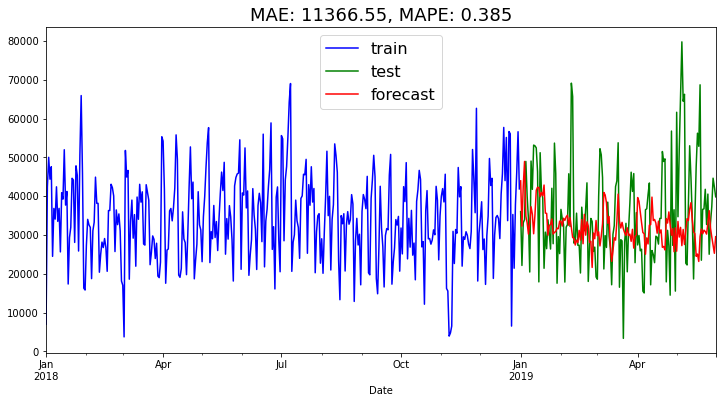

In [406]:

def create_forecaster():
    
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=7, strategy="recursive")
    
    return forecaster

def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test))+1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape
    


best params: {'forecast__window_length': 14}


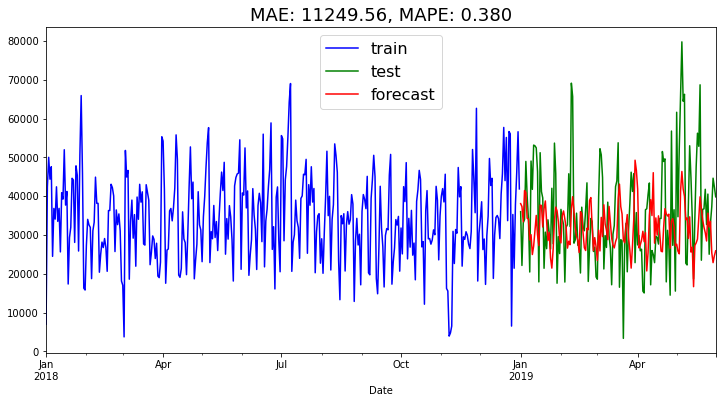

In [407]:
from sktime.transformations.series.detrend import Deseasonalizer

def create_forecaster_w_desesonalizer(sp=7, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=7, strategy="recursive"),
            ),
        ]
    )

    return forecaster
    
forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [7, 14, 21, 28, 35, 42]}

al_lgb_mae, al_lgb_mape = grid_serch_forecaster(
    ts_1_sales, ts_1_sales_valid, forecaster, param_grid
)

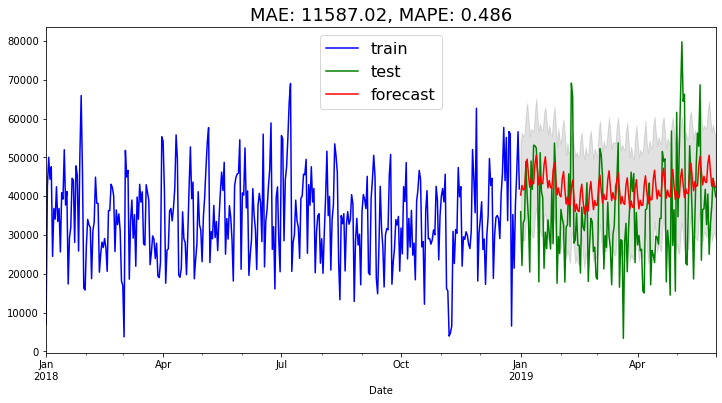

In [408]:

from fbprophet import Prophet

ts_1_sales_pp = ts_1_sales.to_timestamp(freq="d").reset_index()
# Prophet requires specific column names: ds and y
ts_1_sales_pp.columns = ["ds", "y"]

# turning on only yearly seasonality as this is monthly data.
# As the seasonality effects varies across years, we need multiplicative seasonality mode
m = Prophet(
    seasonality_mode="additive",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)
m.fit(ts_1_sales_pp)

future = m.make_future_dataframe(periods=len(ts_1_sales_valid), freq="d")
forecast = m.predict(future)
forecast = forecast.iloc[-len(ts_1_sales_valid):]
forecast.rename(columns={"yhat_lower": "lower", "yhat_upper": "upper"}, inplace=True)
al_pph_mae, al_pph_mape = plot_forecast(ts_1_sales, ts_1_sales_valid, forecast["yhat"], forecast[["lower", "upper"]])

<AxesSubplot:xlabel='Date'>

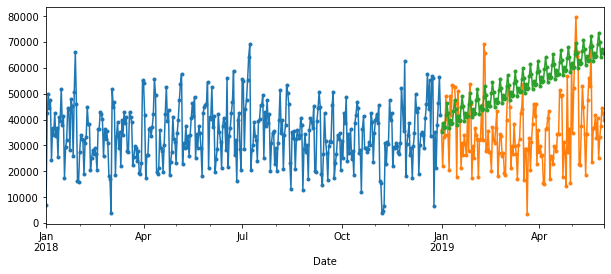

In [409]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=7)
forecaster.fit(ts_1_sales)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ts_1_sales.plot(ax=ax, label='y_train', style='.-')
ts_1_sales_valid.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')

In [430]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(ts_1_sales, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,1,7) [intercept=True]; AIC=7817.510, BIC=7837.009, Time=0.187 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=True]; AIC=7848.199, BIC=7855.999, Time=0.031 seconds
Fit ARIMA(1,0,0)x(1,0,0,7) [intercept=True]; AIC=7816.040, BIC=7831.640, Time=0.219 seconds
Fit ARIMA(0,0,1)x(0,0,1,7) [intercept=True]; AIC=7819.839, BIC=7835.439, Time=0.069 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=False]; AIC=8700.137, BIC=8704.037, Time=0.016 seconds
Fit ARIMA(1,0,0)x(0,0,0,7) [intercept=True]; AIC=7815.964, BIC=7827.664, Time=0.062 seconds
Fit ARIMA(1,0,0)x(0,0,1,7) [intercept=True]; AIC=7815.712, BIC=7831.311, Time=0.088 seconds
Fit ARIMA(1,0,0)x(1,0,1,7) [intercept=True]; AIC=7817.639, BIC=7837.138, Time=0.301 seconds
Fit ARIMA(1,0,0)x(0,0,2,7) [intercept=True]; AIC=7817.523, BIC=7837.023, Time=0.172 seconds
Fit ARIMA(1,0,0)x(1,0,2,7) [intercept=True]; AIC=7819.457, BIC=7842.856, Time=0.507 seconds
Fit ARIMA(0,0,0)x(0,0,1,7) [intercep

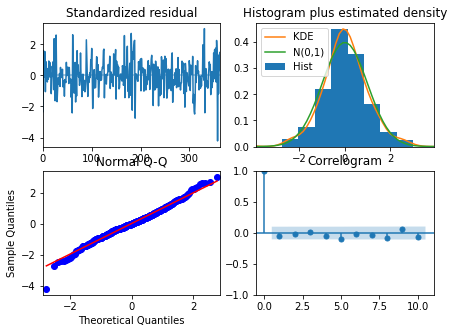

In [431]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

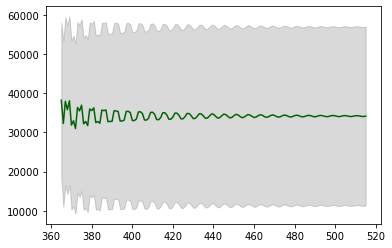

In [432]:
# Forecast
n_periods = len(ts_1_sales_valid.index)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(ts_1_sales), len(ts_1_sales)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
#plt.plot(ts_1_sales)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()
